## Text Summarization

Extractive/Abstractive summarization의 이해

단어장 크기를 줄이는 다양한 text normalization의 적용

seq2seq의 성능을 높이는 Attention Mechanism 적용하기

### Text Summarization텍스트 요약

텍스트량이 많은 기사로부터 텍스트 량이 적은 제목을 만드는 예로, 정보를 압축하는 과정과 같기 때문에 정보 손실의 최소화가 중요.

#### ①Extract Summarization추출적 요약

머신 러닝 방식의 TextRank텍스트 랭크 같은 알고리즘을 사용해서, 본문 중 핵심문장을 추출. 핵심문장 간 호응이 부자연스러울 수 있음.

#### ②Abstractive Summarization추상적 요약

Text Classification문장을 분류하고, RNN을 이용해서 새로운 문장을 생성(Natural Language Generation자연어 생성)

#### Long Term Dependencies장기 의존성 문제

RNN은 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다. 문제의 해결을 위해 등장한 LSTM과 GRU, 추가로 등장한 Attention 어텐션 매커니즘.

## seq2seq + Abstractive Summarization

인코더/디코더로 사용될 LSTM이 바닐라 RNN과 다른 점은, 다음 time step에 hidden state와 cell state를 함께 전달한다는 점이다.

#### 인코더가 디코더에 전달하는 Context vector컨텍스트 벡터 또한 hidden state와 cell state값 모두 존재해야 한다.

seq2seq에서 인코더의 마지막 time step의 hidden state를 context vector로 사용하면 입력 시퀀스의 많은 정보가 손실 되어 있기 때문에,

#### 인코더의 모든 time step의 hidden state가 context vector에 반영되도록 한다(by Attention Mechanism) 단 인코더의 모든 hidden state가 동일한 비중으로 반영되지 않고, 디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산한다. 즉 디코더의 각 time step에 따라 인코더의 hidden state의 가중치 값이 계속 변화한다.

## 데이터 준비

In [1]:
# NLTK 패키지에서 불용어 사전을 다룬로드, 데이터 전처리를 위한 패키지 호출
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [2]:
# 568,454 샘플 중 10만 개의 샘플만 사용하도록 설정

data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data = data[['Text','Summary']]
data.head()

# 랜덤하게 15개 샘플을 출력
data.sample(15)

,Text,Summary
26307,I have a hard time finding hazelnuts for a dec...,These are great
42089,Product was poorly packed and the expiration d...,disappointed
45764,The ginger in this product is just too strong ...,too strong!!
71887,After the latest price increase for Starbucks ...,"Good coffee, low price"
75911,We're very happy with the Smokehouse products ...,Smokehouse delivers great product - not all fr...
49782,"They taste good, they are healthy and low in c...",Kind of can't live without them
74334,When I first tried this sauce it was at an air...,Bring on the HEAT!
6898,This product is tasty -- it's carbonated juice...,"No sugar, but not low-calorie"
65555,These are really great nuts.<br />One thing th...,spicy nuts
71057,"I ordered these for my family, although I do n...",DELICIOUS SNACK


## 데이터 전처리

중복 샘플, Null값이 존재하는 샘플 제거

In [5]:
# 중복 샘플 유무 확인

# nunique() - pandas 라이브러리에서 제공하는 함수로 unique한 값의 개수를 반환
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
# 중복 샘플의 제거
# inplace=True를 설정하면 DataFrame 타입 값을 return하지 않고 data내부를 직접적으로 바꾼다.

data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
# 데이터프레임에 Null값이 남아 있는지 확인

print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', len(data))

전체 샘플수 : 88425


text normalization텍스트 정규화 & 불용어 제거

In [9]:
# text normalization텍스트 정규화를 위한 사전 구성
# text normalization텍스트 정규화 - 같은 의미의 다른 표현(it'll = it will, mustn't = must not)을 통일시켜, 연산의 효율화

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
#Stopwords불용어를 제거하기 위해 NLTK에서 미리 정의하여 제공하고 있는 불용어를 확인

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 정의해놓은 불용어를 사용해서 불용어를 제거하고, 소문자로 변환, html태그를 제거, 정규표현식을 적용

NLTK에서 정의한 불용어가 summary에 남아 있는 편이 Abstractive한 문장을 자연스럽게 만들어줄 것으로 판단되기 때문에 text전처리 시에는 불용어사전을 호출해서 불용어를 제거, summary전처리 시에는 사전을 호출을 하지 않고 불용어가 제거되지 않도록 설정(remove_stopwords, if문 활용)

In [11]:
# 데이터 전처리(정규 표현식 적용 + 불용어 제거) 함수 생성
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트를 소문자로
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a hrer = ...> 등의 html 태크  제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 "제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b'","", sentence) # 소유격 제거 Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등)를 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [12]:
# 전처리 전, 후의 결과를 확인

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br \>for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary: ", preprocess_sentence(temp_summary, False)) # 불용어를 제거하지 않는다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary:  great way to start the day


훈련 데이터 전체에 대해 전처리를 수행하되 Text의 경우는 불용어를 제거하고 Summary의 경우는 불용어를 제거하지 않을 것이기 때문에, 따로 호출해서 진행

In [13]:
# Text에 대한 전처리(정규 표현식 적용 + 불용어 제거)

clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
    
# Text 전처리 확인
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [14]:
# Summary에 대한 전처리(정규 표현식 적용 + 불용어 제거)

clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

# Summary 전처리 확인
print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


전처리를 거친 후, empty sample이 있는지 한 번 더 확인. 쉽게 확인하도록 데이터프레임에 재저장. empty sample이 있다면 Null값을 가진 샘플로 대체

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [16]:
# null 값이 생겼는지 확인

data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [17]:
# Summary 열에 생긴 70개의 Null값을 제거

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


## DATA split

학습을 진행하기 위해 학습에 사용할 데이터의 크기를 결정, 문장의 시작과 끝을 표시한다.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


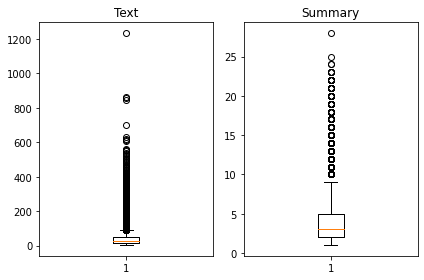

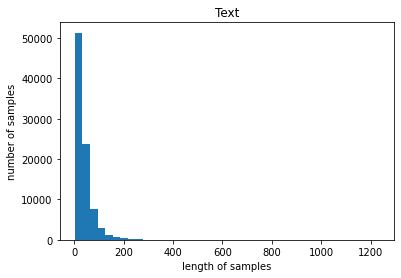

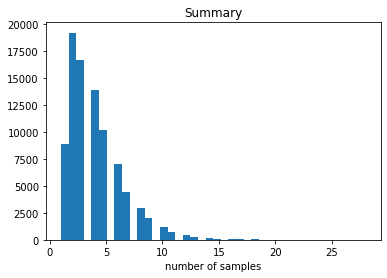

In [18]:
# 정제된 데이터에 대해 샘플의 최대, 최소, 평균 길이를 확인하고 길이 분포를 시각화

import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('lengthof samples')
plt.xlabel('number of samples')
plt.show()

In [19]:
# Text와 Summary의 최대길이를 임의로 정하기

text_max_len = 50
summary_max_len = 8

In [20]:
# Text와 Summary의 최대길이 안에 포함되는 smaple이 얼마나 되는지 확인
# Training 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당되는지 계산.

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [22]:
# 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외

data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


#### 시작 토큰과 종료 토큰 추가하기

디코더의 입력에 해당, 시작 토큰(sos)이 맨 앞에 있는 문장의 이름을 decoder_input

디코더의 출력 또는 레이블에 해당, 종료 토큰(eos)이 맨 뒤에 붙는 문장의 이름을 decoder_target

In [23]:
# Summary 데이터에는 시작토큰과 종료토큰을 추가한다.

data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [24]:
# 인코더의 입력, 디코더의 입력, 레이블을 Numpy 타입으로 저장

encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


## 정수 인코딩

#### 단어 집합(vocabulary) 만들기 및 정수 인코딩

분리 패키지를 사용하지 않고, 직접 코딩을 통해 훈련 데이터와 테스트 데이터를 분리.

In [25]:
# 데이터 분리를 위해, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

indices = np.arange(encoder_input.shape[0]) # endoder_input.shape[0] = encoder_input의 첫번째 차원의 크기 / np.arrange = 정수 배열을 생성.
np.random.shuffle(indices)
print(indices)

[32929 16351   200 ... 31729 25617 54159]


In [26]:
# 만든 정수 시퀀스를 이용해서 데이터의 새믈 순서를 정의 -> 잘 섞인 샘플을 생성.

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [27]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


In [29]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31916
등장 빈도가 6번 이하인 희귀 단어의 수: 23684
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8232
단어 집합에서 희귀 단어의 비율: 74.20729414713624
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.381005785885155


In [31]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3818, 138, 915, 163, 14, 497, 621, 208, 35, 1470, 1249, 238, 875, 863, 586, 1935, 31, 875, 6161, 915, 65, 3890, 3972, 1347, 116, 43, 915, 77, 35, 36, 803, 129, 16, 12, 3, 17, 420, 476, 84, 279, 38, 1965], [5, 2394, 5069, 2, 347, 613, 154, 26, 417, 159, 1042, 299, 370, 2780, 767, 9, 140, 36, 12, 1339, 138, 291, 216, 1235, 1816, 487, 35, 2014, 16, 232, 613, 24, 347, 2107, 14, 110, 27, 3199, 863, 2, 91, 5, 2297, 3, 5], [45, 570, 1145, 99, 1602, 7188, 307, 402, 51]]


In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10478
등장 빈도가 5번 이하인 희귀 단어의 수: 8096
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2382
단어 집합에서 희귀 단어의 비율: 77.26665394159191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.882302276006116


In [35]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 257, 722], [1, 8, 167, 112, 60, 399, 18, 113], [1, 565, 53, 131, 23, 5], [1, 1678], [1, 280, 60, 34, 164]]
target
decoder  [[257, 722, 2], [8, 167, 112, 60, 399, 18, 113, 2], [565, 53, 131, 23, 5, 2], [1678, 2], [280, 60, 34, 164, 2]]


In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1238
삭제할 테스트 데이터의 개수 : 344
훈련 데이터의 개수 : 51417
훈련 레이블의 개수 : 51417
테스트 데이터의 개수 : 12819
테스트 레이블의 개수 : 12819


패딩

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


## Modeling

함수형 API 방식의 인코더 설계

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

디코더 설계

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 출력층 설계

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### 어텐션 메커니즘_디코더의 출력층 설계를 편집해서 성능을 높인다.

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## Training

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)   # val_loss값이 증가하는 현상이 2회 관측되면 조기종료하도록 설정.
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 55s 73ms/step - loss: 2.6976 - val_loss: 2.4109
Epoch 2/50
201/201 [==============================] - 14s 68ms/step - loss: 2.3630 - val_loss: 2.2818
Epoch 3/50
201/201 [==============================] - 14s 69ms/step - loss: 2.2270 - val_loss: 2.1643
Epoch 4/50
201/201 [==============================] - 14s 70ms/step - loss: 2.1095 - val_loss: 2.0677
Epoch 5/50
201/201 [==============================] - 14s 71ms/step - loss: 2.0241 - val_loss: 2.0194
Epoch 6/50
201/201 [==============================] - 15s 72ms/step - loss: 1.9604 - val_loss: 1.9761
Epoch 7/50
201/201 [==============================] - 15s 72ms/step - loss: 1.9051 - val_loss: 1.9467
Epoch 8/50
201/201 [==============================] - 14s 71ms/step - loss: 1.8574 - val_loss: 1.9248
Epoch 9/50
201/201 [==============================] - 14s 71ms/step - loss: 1.8172 - val_loss: 1.9065
Epoch 10/50
201/201 [==============================] - 14s 71ms/step - loss: 1.780

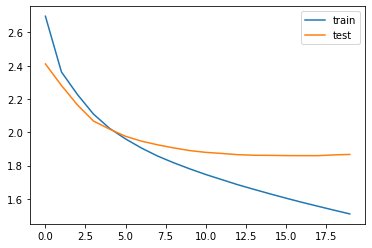

In [43]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Inference  모델 구현

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 생성

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## 모델 테스트하기

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


## PROJECT

In [49]:
from importlib.metadata import version
import nltk
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


데이터 수집

https://github.com/sunnysai12345/News_Summary

In [50]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [51]:
data.sample(10)

,headlines,text
17628,Wasn't right to call nun prostitute but no re...,"Kerala MLA PCÃ¢ÂÂGeorge, who called a nun ""p..."
83654,Maharashtra govt waives farm loans worth Ã¢ÂÂ...,Maharashtra Chief Minister Devendra Fadnavis o...
69202,French Prez Macron flooded with calls after nu...,French President Emmanuel Macron has received ...
35606,Worried about Kapil but don't know what to do:...,"Rajiev Dhingra, the director of Kapil Sharma s..."
33233,Man helping sister file for divorce shot dead ...,A man helping his sister in filing for divorce...
6035,Mastercard to erase Indian clients' data from ...,Global card payments major Mastercard has prop...
4477,Fake news of 'Maharashtra High Court' banning ...,A fake news of 'Maharashtra High Court' bannin...
41392,Rajkumar Hirani a big reason I said yes to Dut...,Sonam Kapoor has said filmmaker Rajkumar Hiran...
84464,"SRK, Suhana, Alia attend launch of eatery desi...","Shah Rukh Khan, along with children Suhana Kha..."
72989,PM Narendra Modi meets 'Biking Queens' from Gu...,Prime Minister Narendra Modi on Monday met the...


#### 데이터 전처리(추상적 요약)

텍스트를 정규화 또는 정제(, 불용어 제거)

#### 어텐션 메커니즘(추상적 요약)

일반적인 seq2seq보다 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 보장.

#### 실제 결과와 요약문 비교하기(추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교

#### Summa을 이용해서 추출적 요약해보기

추상적 요약은, 다양한 표현력을 보장하지만, 난이도가 높다.  추출적 요약은 난이도가 낮은 반면, 문장간의 부자연스러운 호응, 잘못된 요약이 나올 가능성이 있다.

#### 모르겠다. 확인해보자.

9-5. 데이터 전처리를 위해 정규 표현식과 불용어 제거를 위한 함수를 만들었는데, text와 summary를 전처리하면서 '왜 false의 설정이 추가로 필요'한가?

9-6. dataframe 타입?, Numpy 타입?, tensor 타입?

np.arrange(), data.replace()같은 메서드 한 번 더 확인

n_of_val 밸리데이션을 테스트에 사용한다? 이름만 밸리데이션인 것 같다. 해당 데이터가 어디게 사용되는지 확실히 체크할 것.

#### 어탠션 메커니즘 = 유사도

DOT Attention_

제너럴 방식은( 이미지에서) 스코어를 뽑을 때, 정답 스코어가 높도록 학습이 되는 것과 유사하다. 다만 레이블이 없을 뿐, 스코어가 높게 나오도록 W가 학습이 된다.(유사도가 높도록 학습이 된다.)

concatonate Attention_ 콘캣해서 벡터로 만든 다음에, 벡터를 축약시키고, tanh함수를 이용해서 -1~1 사이의 값을 갖도록 변환, 1개의 정수 스코어(결과값)을 갖도록 한다.

RNN을 사용하지 않고, 

한혹 문장을 뽑아내지 못하는 경우가 있는데, (온점 처리가 되지 않아서) 문장을 인식하지 못하기 때문(원본을 사용해보거나, 온점을 생략하지 않도록 조절해보세요그래도 안나온다면 ratio가 낮아서, 문장이 안나올 가능성이 있습니다. )

추상요약과 추출요약을 비교...

프로젝트 참고 : hjkornn-phys